In [145]:
## Dependencies
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import math
delta = 0.025
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np 
import matplotlib 
from sklearn.svm import SVC
import scipy.io as sio ## sio.loadmat from sklearn.model_selection import KFold
from sklearn.model_selection import KFold
import sklearn 
from sklearn.metrics import accuracy_score
from pylab import pcolor, show, colorbar, xticks, yticks
import math
mpl.rc('savefig', dpi=100) #The matplotlib.rc() command can be used to modify multiple settings in a single group at once, using keyword arguments:
plt.style.use('ggplot') #ggplot is a popular theme for charting


## 6.a

In [146]:
mnist_data=sio.loadmat("hw3_mnist_dist/train.mat")
np.random.shuffle(mnist_data["trainX"])

mn_tr=mnist_data["trainX"][:mnist_data["trainX"].shape[0],:-1]
mn_label=mnist_data["trainX"][:mnist_data["trainX"].shape[0],-1]

In [147]:
## Contrast Normalizing images 
## Using Sklearn for this process as suggested by TA in Piazza

mn_train_norm=sklearn.preprocessing.normalize(mnist_data["trainX"][:,:-1], norm='l2')
mn_norm=np.concatenate((mn_train_norm,  mn_label.reshape(mn_label.shape[0],1)), axis=1)

#mn_norm#mnist_data= np.concatenate((mn_train_norm, ))
mn_norm.shape

(60000, 785)

In [148]:
## Function to calculate the mean and covariance matrix for each class 

def parameter_estimator(data,mean=False, covariance=False, LDA=False):
    if mean==True:
        sum_class=np.sum(data, axis=0)
        mean=1/float(data.shape[0]) *sum_class
    if covariance==True:
        covar_cum=np.zeros([data.shape[1], data.shape[1]])
        for i in data:
            deviation= i - mean
            cross_product= np.outer(deviation, deviation)
            covar_cum+=cross_product
        if LDA==True:
            covariance=covar_cum
        else:
            covariance= 1/float(data.shape[0]) * covar_cum
    return (mean, covariance)
            

In [149]:
## Class wise mean and covariance matrix 
values={}
for i in np.unique(mn_label):
    class_values=mnist_data["trainX"][mnist_data["trainX"][:,-1]==i][:,:-1]
    parameters=parameter_estimator(class_values, mean=True, covariance=True)
    values[i]=parameters
    

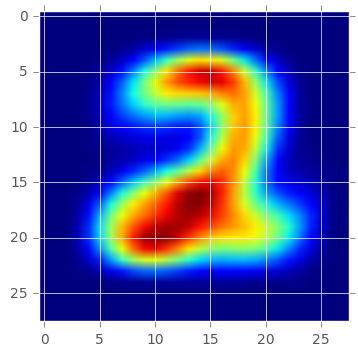

In [154]:
## Sample mean image for 2 

plt.imshow(values[2][0].reshape(28,28))


## 6.b

/Users/suren/anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


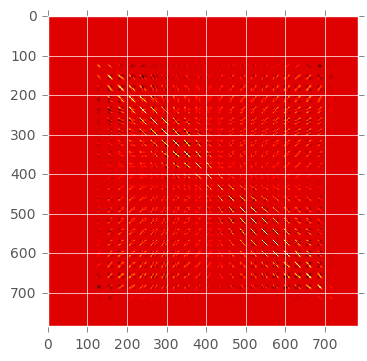

In [155]:
# Vizualising Covariance Matrix for a single class 
for i in np.unique(mn_label):
    plt.imshow(values[8][1], cmap='hot', interpolation='nearest')
    plt.legend()

The covariance matrix for class '8' has been vizualised and shown. As we can see here the diagonal 
elements of the covariance matrix is stong indicating strong variance within the deatures, while most 
of the off diagonal values are less bring or carry low values indicating less correlation among f
the pixels/featurs

## 6c


## i LDA

In [104]:
## Parameter estimation 

def param_lda(data):
    values_lda={}
    for i in np.unique(mn_label):
        class_values=data[data[:,-1]==i][:,:-1]
        parameters=parameter_estimator(class_values, mean=True, covariance=True, LDA=True)
        class_priors=class_values.shape[0]/float(data.shape[0])
        values_lda[i]= (parameters, class_priors)
    ## Computing the overall covariance 
    covar_cum=np.zeros([mn_tr.shape[1],mn_tr.shape[1]])
    for i in np.unique(mn_label):
        covar_cum+=values_lda[i][0][1]
    covar_lda= 1/float(mn_tr.shape[0]) *covar_cum
    #print covar_lda
    return (values_lda, covar_lda)
    

In [105]:
## LDA estimator :
def LDA_estimator(data, valid_set,  c=0.01):
    params= param_lda(data)
    covar=params[1]
    
    covar[np.diag_indices(covar.shape[0])]+=c #Adding an infintesimil number to ensure the matrix is non-singlar
    covar= np.linalg.inv(covar)
    coeff={}
    for i in np.unique(mn_label):#etimatimg coefficients one time 
        class_mu= params[0][i][0][0]
        class_prior= params[0][i][1]
        #print class_prior
        first=np.dot(class_mu,covar)
        second= 0.5*(np.dot(np.dot(class_mu,covar),class_mu))
        third= np.log(class_prior)
        coeff[i]=(first,second, third)   
    predictions=[]    
    for i in valid_set:
        Sample_values=[]
        for cl  in np.unique(mn_label):
            estimate= np.dot(coeff[cl][0],i[:-1])- coeff[cl][1]+coeff[cl][2]
            Sample_values.append((estimate, cl))
        Sample_values.sort()
        pred_cl= Sample_values[-1][1]
        predictions.append(pred_cl)
        
    validation_acc= accuracy_score(predictions,valid_set[:,-1])
    return validation_acc

In [182]:
lda_validation_acc=[]
for i in [100,200,500,1000,2000,  5000, 10000, 30000, 50000]:
    valid_set=mn_norm[-10000:, :]
    training_data=mn_norm[:i, :]
    #print training_data.shape
    val= LDA_estimator(training_data, valid_set, c=0.001)
    print (i, val)
    lda_validation_acc.append((i, val))

(100, 0.70099999999999996)
(200, 0.75119999999999998)
(500, 0.7883)
(1000, 0.82150000000000001)
(2000, 0.84099999999999997)
(5000, 0.8548)
(10000, 0.86419999999999997)
(30000, 0.87480000000000002)
(50000, 0.87739999999999996)


(0.7, 1.1)

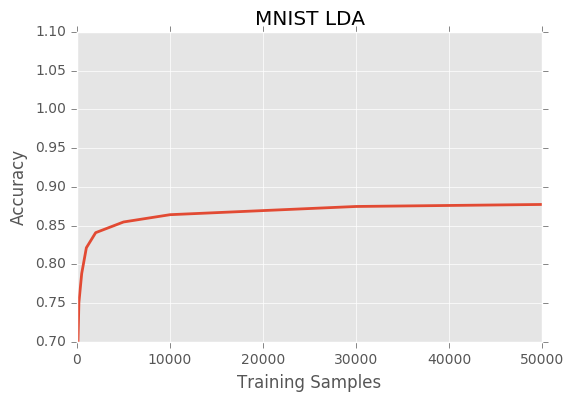

In [186]:
### Plot of Training vs Validation accuracy 
data= [x[0] for x in lda_validation_acc]
accuracy=[x[1] for x in lda_validation_acc]
plt.plot(data, accuracy, linewidth=2.0, label="training")
plt.xlabel("Training Samples")
plt.ylabel("Accuracy")
plt.title("MNIST LDA")
plt.ylim(.70, 1.1)

## ii QDA


In [106]:
## Parameter estimation 

def param_qda(data):
    values_lda={}
    for i in np.unique(mn_label):
        #print i 
        class_values=data[data[:,-1]==i][:,:-1]
        parameters=parameter_estimator(class_values, mean=True, covariance=True, LDA=False)
        class_priors=class_values.shape[0]/float(data.shape[0])
        values_lda[i]= (parameters[0],parameters[1], class_priors)
    return (values_lda)

In [142]:
## QDA estimator :
def QDA_estimator(data, valid_set,  c=0.01, test=False):
    params= param_qda(data)
    coeff={}
    for i in np.unique(mn_label):#etimatimg coefficients one time 
        class_mu= params[i][0]
        class_prior= params[i][2]
        params[i][1][np.diag_indices( params[i][1].shape[0])]+=c
        class_covar_inv=np.linalg.inv(params[i][1])
        class_prior= np.log(class_prior)
        sign, val=np.linalg.slogdet(params[i][1])
        covar_det=sign*val
        coeff[i]=(class_mu,class_covar_inv, covar_det, class_prior)
        
    predictions=[]    
    for i in valid_set:
        Sample_values=[]
        for cl  in np.unique(mn_label):
            diff=(i[:-1]- coeff[cl][0])
            #print diff
            estimate=-0.5 * np.dot(np.dot(diff, coeff[cl][1]),diff) - covar_det+coeff[cl][3]
            Sample_values.append((estimate, cl))
        Sample_values.sort()
        pred_cl= Sample_values[-1][1]
        predictions.append(pred_cl)
    if test:
        return predictions
    else:    
        validation_acc= accuracy_score(predictions,valid_set[:,-1])
        return validation_acc

In [143]:
validation_acc=[]
for c_val in [ 0.00001, 0.001, 0.01]:
    
    for i in  [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]:
        valid_set=mn_norm[-5000:, :]
        training_data=mn_norm[:i, :]
        val= QDA_estimator(training_data, valid_set, c=c_val)
        validation_acc.append((c_val, val, i))
        print (i,val, c_val)

(100, 0.78979999999999995, 1e-05)
(200, 0.84519999999999995, 1e-05)
(500, 0.90800000000000003, 1e-05)
(1000, 0.92179999999999995, 1e-05)
(2000, 0.90980000000000005, 1e-05)
(5000, 0.90639999999999998, 1e-05)
(10000, 0.91000000000000003, 1e-05)
(30000, 0.91420000000000001, 1e-05)
(50000, 0.91439999999999999, 1e-05)
(100, 0.79000000000000004, 0.001)
(200, 0.85019999999999996, 0.001)
(500, 0.92200000000000004, 0.001)
(1000, 0.94359999999999999, 0.001)
(2000, 0.9516, 0.001)
(5000, 0.9556, 0.001)
(10000, 0.95820000000000005, 0.001)
(30000, 0.96099999999999997, 0.001)
(50000, 0.96140000000000003, 0.001)
(100, 0.78939999999999999, 0.01)
(200, 0.85699999999999998, 0.01)
(500, 0.92300000000000004, 0.01)
(1000, 0.93879999999999997, 0.01)
(2000, 0.94420000000000004, 0.01)
(5000, 0.95079999999999998, 0.01)
(10000, 0.95199999999999996, 0.01)
(30000, 0.95479999999999998, 0.01)
(50000, 0.95420000000000005, 0.01)


(0.71, 1.1)

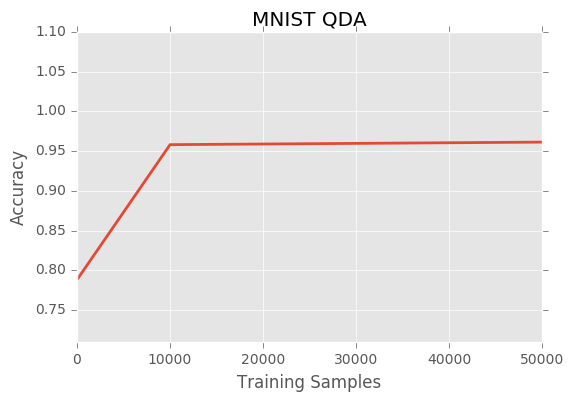

In [144]:
valid_qda_dict={}
for i in validation_acc:
    if i[2] not in valid_qda_dict:
        valid_qda_dict[i[2] ]=i[1]
    else:
        if valid_qda_dict[i[2]]>i[1]:
            pass
        else:
            valid_qda_dict[i[2]]=i[1]
samples=[]
max_acc=[]
for key, value in valid_qda_dict.iteritems():
    samples.append(key)
    max_acc.append(value)

plt.plot(samples[:3], max_acc[:3], linewidth=2.0, label="training")
plt.xlabel("Training Samples")
plt.ylabel("Accuracy")
plt.title("MNIST QDA")
plt.ylim(.71, 1.1)

## iii QDA vs LDA

QDA seems to provide better accuraies compared to LDA achieving around 95% while LDA was able to achieve around 87%. This huge margin in accuracy rates indicate that the decision boundary between mnist digits classes is not linearly seperable and since QDA is non linear and has more parameters, it is able to seperate the digit classes successfuly.  

## iv  Kaggle 

In [123]:
mnist_test=sio.loadmat("hw3_mnist_dist/test.mat")
mn_test_norm=sklearn.preprocessing.normalize(mnist_test["testX"], norm='l2')


In [124]:
test=QDA_estimator(mn_norm, mn_test_norm, c= 0.01, test=True)

In [125]:
id=0
data=[["id","Category"]]
for i in test:
    bb=[id, int(i)]
    data.append(bb)
    id+=1
print len(data)

10001


In [126]:
import csv
with open("mnist_kaggle_3.csv", "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    writer.writerows(data)


### Kaggle Score : 0.95480
##### Username: Surendran Subbiah

## 6d. SPAM 

In [102]:
spam_data=sio.loadmat("dist_2/spam_data.mat")



In [103]:
spam_data=np.concatenate((spam_data["training_data"], spam_data["training_labels"].T), axis=1)
np.random.shuffle(spam_data)
train_samples=spam_data.shape[0]*0.8
spam_train=spam_data[:train_samples,:]
spam_labels=spam_data[:train_samples,-1]
spam_valid=spam_data[train_samples:,:-1]
spam_valid_data=spam_data[train_samples:,-1]

/Users/suren/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/suren/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/suren/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/suren/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


#### SPAM LDA

In [133]:
def param_lda_spam(data):
    values_lda={}
    for i in np.unique(spam_labels):
        #print i 
        class_values=data[data[:,-1]==i][:,:-1]
        parameters=parameter_estimator(class_values, mean=True, covariance=True, LDA=True)
        class_priors=class_values.shape[0]/float(data.shape[0])
        values_lda[i]= (parameters, class_priors)
    ## Computing the overall covariance 
    covar_cum=np.zeros([spam_train[:,:-1].shape[1],spam_train[:,:-1].shape[1]])
    for i in np.unique(spam_labels):
        covar_cum+=values_lda[i][0][1]
    covar_lda= 1/float(spam_train.shape[0]) *covar_cum
    #print covar_lda
    return (values_lda, covar_lda)

## LDA estimator :
def LDA_estimator_spam(data, valid_set,  c=0.01, test=False):
    params= param_lda_spam(data)
    covar=params[1]
    #return covar
    #print covar.shape[0]
    covar[np.diag_indices(covar.shape[0])]+=c #Adding an infintesimil number to ensure the matrix is non-singlar
    covar= np.linalg.inv(covar)
    #q_C=[]
    ## calculate individual Q(C)
    #tr_feature=data[data[:,:-1]]
    #tr_labels= data[data[:, -1]]
    coeff={}
    for i in np.unique(spam_labels):#etimatimg coefficients one time 
        class_mu= params[0][i][0][0]
        class_prior= params[0][i][1]
        #print class_prior
        first=np.dot(class_mu,covar)
        second= 0.5*(np.dot(np.dot(class_mu,covar),class_mu))
        third= np.log(class_prior)
        coeff[i]=(first,second, third)   
    predictions=[]    
    for i in valid_set:
        Sample_values=[]
        for cl  in np.unique(spam_labels):
            estimate= np.dot(coeff[cl][0],i)- coeff[cl][1]+coeff[cl][2]
            Sample_values.append((estimate, cl))
        Sample_values.sort()
        pred_cl= Sample_values[-1][1]
        predictions.append(pred_cl)
    if test:
        return predictions
    else:
        validation_acc= accuracy_score(predictions,spam_valid_data)
        return validation_acc

In [114]:

#LDA_spam_valid= LDA_estimator(spam_train, spam_valid, c=0.01)
val= LDA_estimator_spam(spam_train, spam_valid, c=0.001)

9364
9597


In [115]:
val

0.75258384307108206

#### SPAM QDA

In [116]:
# QDA
## Parameter estimation 

def param_qda_spam(data):
    values_lda={}
    for i in np.unique(spam_labels):
        #print i 
        class_values=data[data[:,-1]==i][:,:-1]
        parameters=parameter_estimator(class_values, mean=True, covariance=True, LDA=False)
        class_priors=class_values.shape[0]/float(data.shape[0])
        values_lda[i]= (parameters[0],parameters[1], class_priors)
    return (values_lda)

## QDA estimator :
def QDA_estimator_spam(data, valid_set,  c=0.01, test=False):
    params= param_qda_spam(data)
    #print params[0]
   #covar=params[1]
    #return covar
    #print covar.shape[0]
    #covar[np.diag_indices(covar.shape[0])]+=c #Adding an infintesimil number to ensure the matrix is non-singlar
    #covar= np.linalg.inv(covar)
    #q_C=[]
    ## calculate individual Q(C)
    #tr_feature=data[data[:,:-1]]
    #tr_labels= data[data[:, -1]]
    coeff={}
    for i in np.unique(spam_labels):#etimatimg coefficients one time 
        class_mu= params[i][0]
        class_prior= params[i][2]
        params[i][1][np.diag_indices( params[i][1].shape[0])]+=c
        class_covar_inv=np.linalg.inv(params[i][1])
        #print class_prior
        class_prior= np.log(class_prior)
        #print class_prior
        #covar_det=float(np.linalg.det(params[i][1]))
        #non_zero_eig=np.log(np.nonzero(np.linalg.eig(params[i][1])))
        sign, val=np.linalg.slogdet(params[i][1])
        
        covar_det=sign*val
        #print covar_det
        coeff[i]=(class_mu,class_covar_inv, covar_det, class_prior)
        
    predictions=[]    
    for i in valid_set:
        Sample_values=[]
        for cl  in np.unique(spam_labels):
            diff=(i- coeff[cl][0])
            #print diff
            estimate=-0.5 * np.dot(np.dot(diff, coeff[cl][1]),diff) - covar_det+coeff[cl][3]
            Sample_values.append((estimate, cl))
        Sample_values.sort()
        pred_cl= Sample_values[-1][1]
        predictions.append(pred_cl)
    if test:
        return predictions
    else:
        validation_acc= accuracy_score(predictions,spam_valid_data)
        return validation_acc


In [117]:
val=QDA_estimator_spam(spam_train, spam_valid, c=0.01)

9364
9597


In [118]:
val

0.71060957603881036

### 6.e. SPAM Kaggle 

In [135]:
spam_data=sio.loadmat("dist_2/spam_data.mat")
spam_test=spam_data["test_data"]
spam_train=np.concatenate((spam_data["training_data"], spam_data["training_labels"].T), axis=1)
np.random.shuffle(spam_train)
spam_labels=spam_train[:,-1]


In [136]:
test_spam=LDA_estimator_spam(spam_train, spam_test, c=0.001, test=True)

In [137]:
id=0
data=[["id","Category"]]
for i in test_spam:
    bb=[id, int(i)]
    data.append(bb)
    id+=1
print len(data)

10001


In [138]:
import csv
with open("spam_kaggle_3.csv", "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    writer.writerows(data)

## Kaggle Score SPAM classification: 0.75520
##### Username: Surendran Subbiah

In [230]:

import math

## Problem 2

In [157]:

x = np.arange(-3.0, 3.0, delta)
y = np.arange(-2.0, 2.0, delta)
X, Y = np.meshgrid(x, y)



### 2.a 

<a list of 9 text.Text objects>

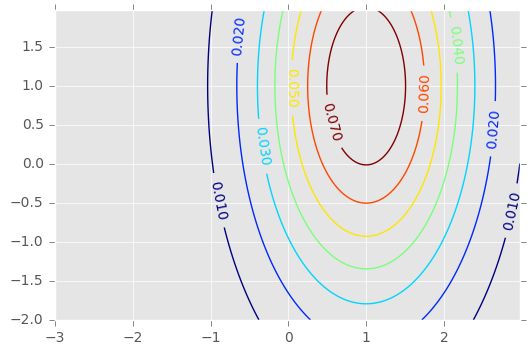

In [158]:
Z1 = mlab.bivariate_normal(X, Y, 1.0, 2.0, 1.0, 1.0, 0.0)
#Source http://stackoverflow.com/questions/27139427/trying-to-plot-contours-of-bivariate-normal-wont-work-with-a-correlation-term
plt.figure()
contour = plt.contour(X, Y, Z1)
plt.clabel(contour, inline=1, fontsize=10)

### 2.b

<a list of 6 text.Text objects>

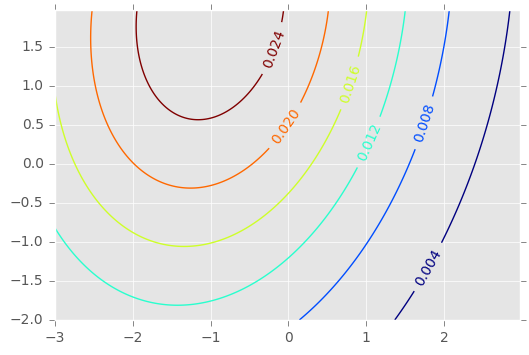

In [159]:
Z2 = mlab.bivariate_normal(X, Y, 2.0, 3.0, -1.0, 2.0, 1.0)

plt.figure()
contour = plt.contour(X, Y, Z2)
plt.clabel(contour, inline=1, fontsize=10)

### 2.c

<a list of 7 text.Text objects>

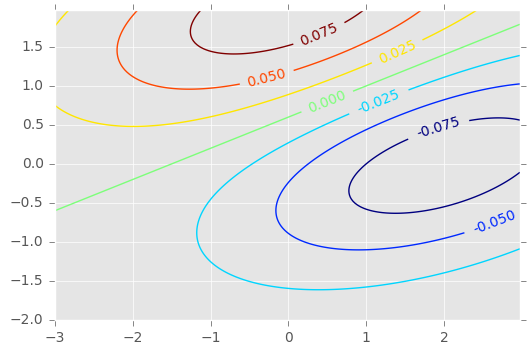

In [160]:
Z3_1 = mlab.bivariate_normal(X, Y, 2.0, 1.0, 0.0, 2.0, 1.0)
Z3_2 = mlab.bivariate_normal(X, Y, 2.0, 1.0, 2.0, 0.0, 1.0)

Z3=Z3_1-Z3_2

plt.figure()
contour = plt.contour(X, Y, Z3)
plt.clabel(contour, inline=1, fontsize=10)

### 2.d

<a list of 7 text.Text objects>

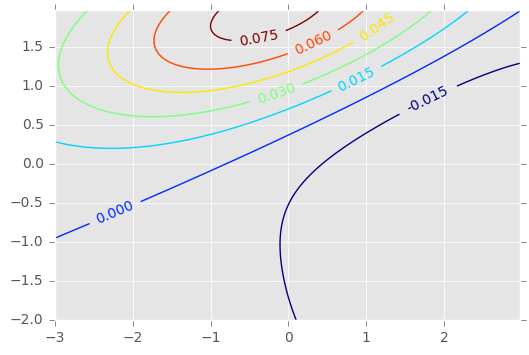

In [161]:
Z4_1 = mlab.bivariate_normal(X, Y, 2.0, 1.0, 0.0, 2.0, 1.0)
Z4_2 = mlab.bivariate_normal(X, Y, 2.0, 3.0, 2.0, 0.0, 1.0)

Z4=Z4_1-Z4_2

plt.figure()
contour = plt.contour(X, Y, Z4)
plt.clabel(contour, inline=1, fontsize=10)

### 2.e

<a list of 7 text.Text objects>

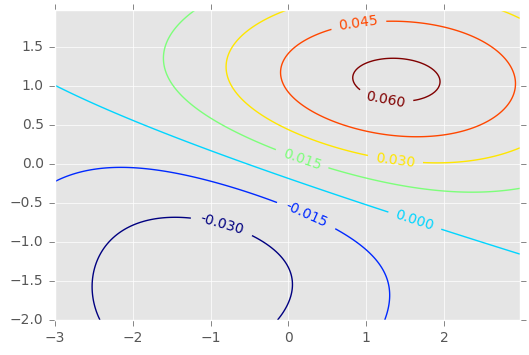

In [162]:
Z5_1 = mlab.bivariate_normal(X, Y, 2.0, 1.0, 1.0, 1.0, 0.0)
Z5_2 = mlab.bivariate_normal(X, Y, 2.0, 2.0, -1, -1, 1.0)

Z5=Z5_1-Z5_2

plt.figure()
contour = plt.contour(X, Y, Z5)
plt.clabel(contour, inline=1, fontsize=10)

## Problem 3 

In [163]:


mu_1, sigma_1=3,np.sqrt(9)
mu_2, sigma_2=4,np.sqrt(4)
X_1=np.random.normal(mu_1, math.sqrt(sigma_1), 100)
X_2=0.5*X_1+np.random.normal(mu_2, math.sqrt(sigma_2), 100)
X_vec=np.vstack((X_1, X_2.T))



### 3.a

In [164]:
# Mean
mean=X_vec.mean(axis=1)
mean

array([ 3.30413504,  5.63222684])

### 3.b

In [165]:
# Covariance
covariance= np.cov(X_vec)
covariance

array([[ 2.20316705,  1.05050836],
       [ 1.05050836,  2.11903406]])

### 3.c

In [166]:
# Eigenvalue and Eigenvector
eig_val, eig_vec=np.linalg.eig(covariance)
print "The eigen vector"
print(eig_vec)
print "The eigen vector"
print (eig_val)


The eigen vector
[[ 0.72111437 -0.69281604]
 [ 0.69281604  0.72111437]]
The eigen vector
[ 3.21245083  1.10975028]


In [167]:
## Check if eigen vectors are orthogonal :

np.dot(eig_vec[0], eig_vec[1])

0.0

### 3.d

In [168]:
# Scaling eigenvector 
scale_eig=eig_vec.T.dot(np.diag(eig_val))
arrow_1=np.vstack((mean, scale_eig.T[0])).T
arrow_2=np.vstack((mean, scale_eig.T[1])).T


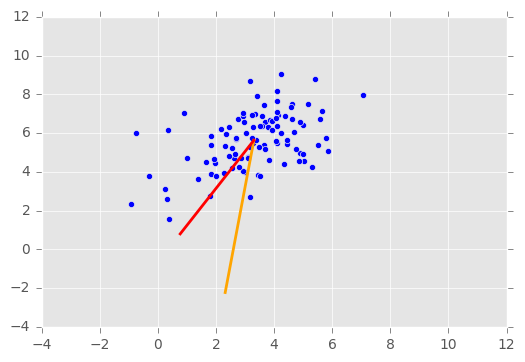

In [169]:
plt.scatter(X_1, X_2)
plt.plot(arrow_1[0],arrow_1[1], color= "orange", linewidth=2.0)
plt.plot(arrow_2[0],arrow_2[1], color = "red", linewidth=2.0)
plt.xlim(-4,12)
plt.ylim(-4,12)
plt.show()

Note:
The eigen vectors don't look orthogonal due to aspect ratio issue with matplotlib, I am unable to 
resolve it 

### 3.e

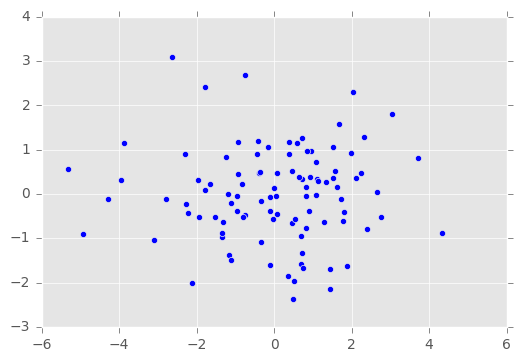

In [170]:
centered_vec= (X_vec-mean.reshape(2,1))
rotate= eig_vec.T.dot(centered_vec)

plt.scatter(rotate[0], rotate[1])